train on the largest set

split the largest set into train and test

test the text files at the same length
- each O is a single file
- use length 500 (cut off any extra or discard too short files)

make one large observation sequence concatenating all the files together to train
- might have to fix T (to 30k)
    - won't take hours but will take a while

How can i fix the value M to a given number:
- collect the full dataset train and test
- read all the files one after another
- use a dictionary where the key is the opcode name and the value is the count of that oppcode occurence
- sort the dictionary by the value number

In [39]:
import os
import pandas as pd

In [40]:
# prepare training and testing directory:
# get the number of observations in each
parent_directory = "/Users/andrewtownsend/Desktop/SJSU/CS131/midterm/Malicia (Big 3 - Opcodes)"

# sequenceCounts = pd.DataFrame(columns=['class_name', 'file_name', 'opcode_count'])
temp_dict = []

for sub_directory in os.listdir(parent_directory):
    sub_directory_path = os.path.join(parent_directory, sub_directory)
    if os.path.isdir(sub_directory_path):

        for file_name in os.listdir(sub_directory_path):
            file_path = os.path.join(sub_directory_path, file_name)
            if os.path.isfile(file_path):
                with open(file_path, 'r') as fp:
                    num_lines = len(fp.readlines())
                    temp_dict.append({'class_name': sub_directory, 'file_name': file_name, 'opcode_count': num_lines})

sequence_counts = pd.DataFrame(temp_dict)


In [41]:
print(f'shape: {sequence_counts.shape}')
group_counts = sequence_counts.groupby('class_name').size()
print(group_counts)

shape: (7801, 3)
class_name
winwebsec     4360
zbot          2136
zeroaccess    1305
dtype: int64


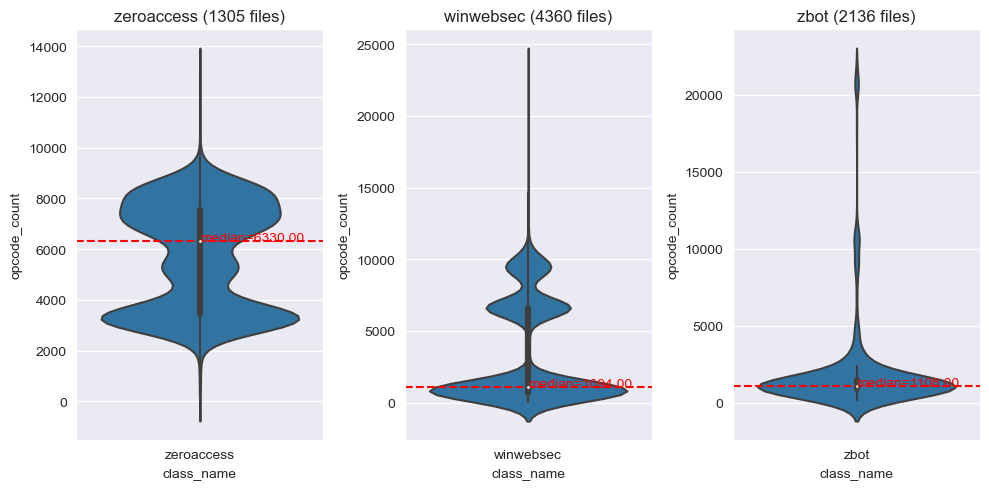

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a list of class names to plot
class_names = sequence_counts['class_name'].unique()

# create subplots for each class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# loop over the class names and plot a violin plot for each class
for i, class_name in enumerate(class_names):
    data = sequence_counts[sequence_counts['class_name'] == class_name]
    sns.violinplot(x='class_name', y='opcode_count', data=data, ax=axes[i])

    # add title with class name and file count
    file_count = len(data['file_name'].unique())
    title = f"{class_name} ({file_count} files)"
    axes[i].set_title(title)

    # add a horizontal line at the mean value
    median_value = data['opcode_count'].median()
    axes[i].axhline(median_value, color='red', linestyle='--')
    axes[i].text(0, median_value+0.5, f"median={median_value:.2f}", color='red', fontsize=10)

plt.tight_layout()
plt.show()


##Yes but what does this mean

The graph shows the size and distribution of each category. We can see that the winwebsec category has significantly more samples in it than either of the other two categories. We will choose this category as our training set. This decision will maximize the sixes of our training set and our test sets. We can also see that the median size of the winwebsec class of virus file is around 1000 opcodes. We want to test our HMM model on a uniform sequence length, this will ensure that no bias is created against longer files because longer files will inherently have a lower probability score according to our HMM. We will choose a standard length to truncate all of our observations to, so that we make more accurately classify them. This length will be 500 opcodes (cuz proff Di Troia said so in class). Any file with less than 500 opcodes will be discarded and all files with more than 500 opcodes will be truncated.

In [43]:
# make a hella long list of opcodes for the observation sequence of the winwebsec virus category
# concatenate the contents of each file together into a long list of

In [44]:
parent_directory = "/Users/andrewtownsend/Desktop/SJSU/CS131/midterm/Malicia (Big 3 - Opcodes)"
df_filtered = sequence_counts[sequence_counts['class_name'] =='winwebsec']
print(df_filtered)

     class_name                                         file_name  \
1305  winwebsec  0d424ab66081e9562b4a1136d5fc1de7f6b27a90.asm.txt   
1306  winwebsec  114e7b5acd7894eba0ffa6d7d7b7edd2058c50d4.asm.txt   
1307  winwebsec  551369dafcb66d1f1137631c32e57c54422dcfed.asm.txt   
1308  winwebsec  760ff1f98508c4efb2b3db9f3392ba6c154ca253.asm.txt   
1309  winwebsec  1fdcdb634aae85a9682a5c49372b16846fe16a88.asm.txt   
...         ...                                               ...   
5660  winwebsec  e256be2592ba8b66f8320d40d99ce27022194429.asm.txt   
5661  winwebsec  c75d34c98d977eec8954abb3ce869af300c47a66.asm.txt   
5662  winwebsec  8942ca0c604bc743f836a32040a251510b79965b.asm.txt   
5663  winwebsec  ff4b2489528f5a127163c7df6513b9d42fd10e80.asm.txt   
5664  winwebsec  4aa883abfca5dd90c8282dbcb661bf35a16ab7aa.asm.txt   

      opcode_count  
1305           962  
1306          1196  
1307          6504  
1308           637  
1309          9502  
...            ...  
5660          9513  
566

In [45]:
# concatenate together all opcodes from the winwebsec files
observation_sequence = []
for index, row in df_filtered.iterrows():
    winwebsec_file_path = os.path.join(parent_directory, row['class_name'], row['file_name'])
    with open(winwebsec_file_path, 'r') as fp:
        temp = map(lambda s: s.strip(), fp.readlines())
        observation_sequence.extend(temp)

In [46]:
print(observation_sequence.__len__())

15190157


In [47]:
unique_elements = set(observation_sequence)
print(len(unique_elements))

332


In [48]:
print(observation_sequence[0:15])

['push', 'mov', 'sub', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov']


The length of the observation sequence is over 15mil opcodes, this is an impractically large amount of data to train our HMM on because the length of our training scales linearly with the size of T (the length of our observation sequence). In order to make training more practical, we can shorten the length to around 30k opcodes.

Here we make a dataframe with one column holding the name of the opcode and another column holding the count of the occurances of that opcode in the observation sequence made from the concatenated winwebsec viruses

In [49]:
# gather information about the distribution of the usage of the opcodes
opcode_use_counts = {}
for element in observation_sequence:
    if element in opcode_use_counts:
        opcode_use_counts[element] += 1
    else:
        opcode_use_counts[element] = 1

opcode_tuples = [(key, value) for key, value in opcode_use_counts.items()]
opcode_counts_df = pd.DataFrame(opcode_tuples, columns=['opcode', 'count'])

In [50]:
print(opcode_counts_df.shape)
print(opcode_counts_df)

(332, 2)
      opcode    count
0       push  2331786
1        mov  3697930
2        sub   276556
3        lea   450011
4       call  1062400
..       ...      ...
327     movq        2
328  fsincos        2
329    cmovs        2
330   pminub        2
331    paddb        2

[332 rows x 2 columns]


In [51]:
print('other' in opcode_counts_df['opcode'].values)
# add other to dataframe with count zero so that
opcode_counts_df = opcode_counts_df.append({'opcode': 'other', 'count': 0}, ignore_index=True)
print(opcode_counts_df)

False
      opcode    count
0       push  2331786
1        mov  3697930
2        sub   276556
3        lea   450011
4       call  1062400
..       ...      ...
328  fsincos        2
329    cmovs        2
330   pminub        2
331    paddb        2
332    other        0

[333 rows x 2 columns]


/var/folders/q4/pd_htb0549ngh8pg5b0bcg5h0000gn/T/ipykernel_5615/2965878051.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  opcode_counts_df = opcode_counts_df.append({'opcode': 'other', 'count': 0}, ignore_index=True)


Sort the dataframe holding the counts of the usages of each opcode, then record the count of the 29th most frequent opcode. Sum the counts of all the opcodes that occur less frequently than the 29th most frequent opcode then remove those opcodes from the dataframe. Add a new row to the filtered dataframe with the opcode name other and the count the sum of the removed opcode counts

In [52]:
# compute the count of the 30th most infrequent opcode
noise_reduction_constant = 29   # this is the number of not junk opcodes (will add one junk opcode for total of 30)
opcode_counts_df = opcode_counts_df.sort_values('count', ascending=False)
min_count = opcode_counts_df.iloc[noise_reduction_constant - 1]['count']
print("min count: ", min_count)

to_filter_df = opcode_counts_df[opcode_counts_df['count'] < min_count]
other_count = to_filter_df['count'].sum()
opcode_counts_filtered_df = opcode_counts_df[opcode_counts_df['count'] >= min_count]
opcode_counts_filtered_df = opcode_counts_filtered_df.append({'opcode': 'other', 'count': other_count}, ignore_index=True)
print("opcode_counts_filtered_df.shape: ", opcode_counts_filtered_df.shape)
print("should be other row:\n", opcode_counts_filtered_df[opcode_counts_filtered_df['opcode'] == 'other'])
print("opcode counts filtered:\n", opcode_counts_filtered_df)

min count:  32559
opcode_counts_filtered_df.shape:  (30, 2)
should be other row:
    opcode   count
29  other  470339
opcode counts filtered:
    opcode    count
0     mov  3697930
1    push  2331786
2    call  1062400
3     cmp   983246
4     pop   866858
5      jz   654867
6     add   578018
7     jnz   576689
8    test   461446
9     lea   450011
10    jmp   441766
11   retn   391068
12    xor   390221
13    and   285420
14    sub   276556
15    inc   268905
16     or   219949
17    dec   120690
18    shr   118622
19     jb   114562
20  leave    81130
21  movzx    57910
22    rep    48728
23    jnb    47481
24    jbe    46487
25    shl    43927
26    neg    35963
27     ja    34623
28    sbb    32559
29  other   470339


/var/folders/q4/pd_htb0549ngh8pg5b0bcg5h0000gn/T/ipykernel_5615/928836255.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  opcode_counts_filtered_df = opcode_counts_filtered_df.append({'opcode': 'other', 'count': other_count}, ignore_index=True)


<Axes: xlabel='opcode'>

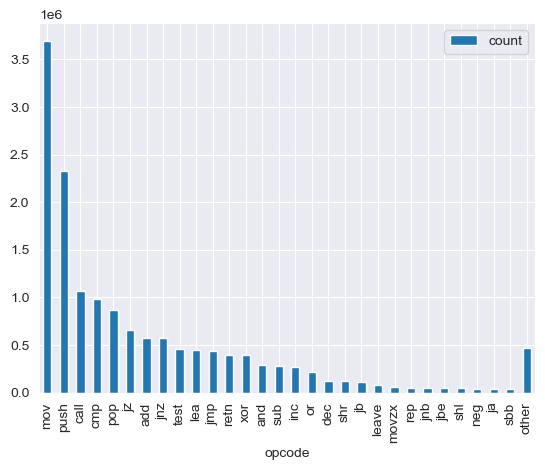

In [53]:
# create a barcode graph showing the distribution of the opcode counts
opcode_counts_filtered_df.plot.bar(x='opcode', y='count', rot=90)

From this bar graph we can see that we might even be able to be more aggressive with our noise reduction because of the relatively small size of the 23rd through 29th opcodes

Build the two new observation sequences, one without any noise filtering and one with noise filtering

In [54]:
# build one training observation sequence with all the opcodes up to 30k
noisy_observation_sequence = []
noisy_observation_sequence.extend(observation_sequence[0:30000])
print("num unique opcodes in noisy sequence: ", len(set(noisy_observation_sequence)))
print(f'length of noisy sequence: {len(noisy_observation_sequence)}')
# build another observation sequence with the 29 most frequent opcodes and any less frequent opcodes interpreted as noise
filtered_observation_sequence = []
for i in range(30000):
    if (opcode_counts_filtered_df['opcode'].eq(observation_sequence[i])).any():
        filtered_observation_sequence.append(observation_sequence[i])
    else:
        filtered_observation_sequence.append('other')
print("num unique opcode in filtered sequence: ", len(set(filtered_observation_sequence)))
print("length of filtered sequecne: ", len(filtered_observation_sequence))

num unique opcodes in noisy sequence:  142
length of noisy sequence: 30000
num unique opcode in filtered sequence:  30
length of filtered sequecne:  30000


In [55]:
import numpy as np
# map each opcode to an integer and replace the opcodes in the observation sequence with the observation number
noisy_observation_sequence_numeric = \
    [np.where(opcode_counts_df['opcode'] == i)[0][0] for i in noisy_observation_sequence]
filtered_observation_sequence_numeric = \
    [np.where(opcode_counts_filtered_df['opcode'] == i)[0][0] if i in opcode_counts_filtered_df['opcode'].values
     else np.where(opcode_counts_filtered_df['opcode'] == 'other') for i in filtered_observation_sequence]

In [56]:
print(type(np.where(opcode_counts_df['opcode'] == 'push')[0][0]))
print(noisy_observation_sequence[0:100])
print(noisy_observation_sequence_numeric[0:100])
print(f'num unique unfiltered: {len(set(noisy_observation_sequence_numeric))}')

print('\n\n',filtered_observation_sequence[0:100])
print(filtered_observation_sequence_numeric[0:100])
print(f'num unique filtered: {len(set(filtered_observation_sequence_numeric))}')

<class 'numpy.int64'>
['push', 'mov', 'sub', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'lea', 'push', 'lea', 'push', 'call', 'test', 'jz', 'push', 'lea', 'push', 'call', 'lea', 'push', 'push', 'push', 'push', 'call', 'mov', 'add', 'mov', 'lea', 'push', 'lea', 'push', 'push', 'push', 'push', 'mov', 'push', 'call', 'lea', 'push', 'push', 'push', 'mov', 'push', 'call', 'lea', 'push', 'push', 'push', 'push', 'mov', 'push', 'call', 'lea', 'push', 'push', 'push', 'push', 'mov', 'push', 'call', 'scasb', 'fdivr', 'cdq', 'retn', 'call', 'mov', 'movzx']
[1, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 1, 9, 1, 2, 8, 5, 1, 9, 1, 2, 9, 1, 1, 1, 1, 2, 0, 6, 0, 9, 1, 9, 1, 1, 1, 1, 0, 1, 2, 9, 1, 1, 1, 0, 1, 2, 

In [87]:
# make a dictionary to hold the noisy numeric sequence mapping
noisy_numeric_mapping = {}
for opcode in set(noisy_observation_sequence):
    noisy_numeric_mapping[opcode] = np.where(opcode_counts_df['opcode'] == opcode)[0][0]

In [93]:
temp_list = list(noisy_numeric_mapping.items())
print(sorted(temp_list, key= lambda x: x[1]))

[('mov', 0), ('push', 1), ('call', 2), ('cmp', 3), ('pop', 4), ('jz', 5), ('add', 6), ('jnz', 7), ('test', 8), ('lea', 9), ('jmp', 10), ('retn', 11), ('xor', 12), ('and', 13), ('sub', 14), ('inc', 15), ('or', 16), ('dec', 17), ('shr', 18), ('jb', 19), ('leave', 20), ('movzx', 21), ('rep', 22), ('jnb', 23), ('jbe', 24), ('shl', 25), ('neg', 26), ('ja', 27), ('sbb', 28), ('jl', 29), ('cld', 30), ('jge', 31), ('std', 32), ('sar', 33), ('not', 34), ('jle', 35), ('imul', 36), ('stosd', 37), ('int', 38), ('mul', 39), ('jg', 40), ('movsd', 41), ('movsx', 42), ('fld', 43), ('fstp', 44), ('setz', 45), ('xchg', 46), ('div', 47), ('adc', 48), ('nop', 49), ('stosb', 50), ('setnz', 51), ('cdq', 52), ('rcr', 53), ('idiv', 54), ('js', 55), ('bt', 57), ('bts', 58), ('repe', 59), ('fcomp', 60), ('retf', 61), ('fnstsw', 62), ('fldcw', 63), ('jecxz', 64), ('repne', 65), ('in', 67), ('out', 68), ('jns', 69), ('xlat', 70), ('fmul', 71), ('sahf', 72), ('cwde', 73), ('wait', 74), ('popa', 75), ('rol', 76), (

In [88]:
print(noisy_numeric_mapping)

{'cld': 30, 'les': 140, 'setnle': 78, 'neg': 26, 'wait': 74, 'sar': 33, 'jo': 87, 'shl': 25, 'outsd': 111, 'jecxz': 64, 'fstp': 44, 'lds': 125, 'xlat': 70, 'js': 55, 'popf': 121, 'lodsd': 99, 'arpl': 107, 'fisub': 157, 'repe': 59, 'setl': 105, 'jnb': 23, 'outs': 190, 'or': 16, 'fld': 43, 'fdivrp': 149, 'retf': 61, 'adc': 48, 'fmul': 71, 'jns': 69, 'shr': 18, 'daa': 100, 'xchg': 46, 'ror': 81, 'jg': 40, 'sal': 128, 'jno': 108, 'movsb': 112, 'setnz': 51, 'fcom': 136, 'rep': 22, 'leave': 20, 'fisttp': 147, 'pop': 4, 'inc': 15, 'fldcw': 63, 'cmpsd': 130, 'call': 2, 'aam': 109, 'jbe': 24, 'into': 118, 'fpatan': 204, 'aad': 90, 'fdiv': 83, 'std': 32, 'nop': 49, 'cmc': 113, 'repne': 65, 'cmp': 3, 'movsx': 42, 'hlt': 126, 'pusha': 79, 'fucomi': 216, 'iret': 137, 'rcl': 139, 'out': 68, 'das': 119, 'lea': 9, 'mov': 0, 'fcomp': 60, 'movsd': 41, 'loopne': 103, 'scasd': 129, 'fild': 122, 'dec': 17, 'aas': 98, 'div': 47, 'fdivr': 144, 'mul': 39, 'jp': 80, 'setalc': 104, 'movsw': 106, 'ja': 27, 'fstc

In [86]:
print('other' in noisy_numeric_mapping)

False


Train the HMM on the noisy sequence

In [57]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.hmm import CategoricalHMM

In [58]:
np_noisy_training_sequence = np.array([noisy_observation_sequence_numeric])
print(np_noisy_training_sequence.shape)
print(np.unique(np_noisy_training_sequence))
np_filtered_training_sequence = np.array([filtered_observation_sequence_numeric])
print(np_filtered_training_sequence.shape)
print(np.unique(np_filtered_training_sequence))

(1, 30000)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  67  68  69  70  71  72  73
  74  75  76  78  79  80  81  83  84  85  86  87  88  89  90  93  95  96
  97  98  99 100 101 103 104 105 106 107 108 109 111 112 113 115 116 117
 118 119 120 121 122 125 126 127 128 129 130 132 133 134 135 136 137 138
 139 140 141 144 147 149 155 156 157 159 164 165 178 190 204 216]
(1, 30000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [71]:
classifierHMM_noisy = CategoricalHMM(n_components=2, verbose=True, random_state=42)
classifierHMM_noisy.fit(np_noisy_training_sequence)

         1     -164872.8448             +nan
         2      -86525.8138      +78347.0310
         3      -86510.9161         +14.8976
         4      -86499.3322         +11.5839
         5      -86489.8410          +9.4912
         6      -86481.7740          +8.0670
         7      -86474.7111          +7.0630
         8      -86468.3515          +6.3596
         9      -86462.4602          +5.8912
        10      -86456.8434          +5.6168


CategoricalHMM(n_components=2,
               random_state=RandomState(MT19937) at 0x7FBDD437B540,
               verbose=True)

In [72]:
classifierHMM_filtered = CategoricalHMM(n_components=2, verbose=True, random_state=42)
classifierHMM_filtered.fit(np_filtered_training_sequence)

         1     -105721.2103             +nan
         2      -81865.1334      +23856.0769
         3      -81841.1382         +23.9952
         4      -81821.3335         +19.8047
         5      -81803.7603         +17.5732
         6      -81787.3333         +16.4270
         7      -81771.3615         +15.9719
         8      -81755.3724         +15.9891
         9      -81739.0375         +16.3349
        10      -81722.1357         +16.9018


CategoricalHMM(n_components=2,
               random_state=RandomState(MT19937) at 0x7FBDD437B840,
               verbose=True)

##Make a testing set:
- take samples from winwebsec that were not used for training
- take samples from both zeroaccess and zbot
- make a set of both filtered and unfiltered samples
- test those samples on their respective classifier

In [61]:
zbot_files_df = sequence_counts[sequence_counts['class_name'] == 'zbot']
zeroaccess_files_df = sequence_counts[sequence_counts['class_name'] == 'zeroaccess']
winwebsec_files_df = sequence_counts[sequence_counts['class_name'] == 'winwebsec']

In [62]:
# make a list of ~100 observations to be scored for each class
parent_directory = "/Users/andrewtownsend/Desktop/SJSU/CS131/midterm/Malicia (Big 3 - Opcodes)"
file_length = 1000

def get_test_sequences(num_sequences, file_df, parent_directory, file_length):
    temp_observation_sequences = []
    temp_generator = file_df.iterrows()

    while len(temp_observation_sequences) < num_sequences:
        index, row = next(temp_generator)
        temp_file_path = os.path.join(parent_directory, row['class_name'], row['file_name'])
        with open(temp_file_path, 'r') as fp:
            temp_file_content = list(map(lambda s: s.strip(), fp.readlines()[0:file_length]))
            if len(temp_file_content) == file_length:
                temp_observation_sequences.append(temp_file_content)

    return temp_observation_sequences

zbot_observation_sequences = get_test_sequences(100, zbot_files_df, parent_directory, file_length)
zeroaccess_observation_sequences = get_test_sequences(100, zeroaccess_files_df, parent_directory, file_length)
winwebsec_observation_sequences = get_test_sequences(100, winwebsec_files_df, parent_directory, file_length)

In [63]:
# replace the strings in the testing sets with integers from the dataframes
def replace_with_numiric(observation_sequences, opcode_counts_df):

    all_opcodes = set(opcode_counts_df['opcode'].values)
    numeric_sequences = []
    for i in range(len(observation_sequences)):
        temp_sequence = []
        for j in range(len(observation_sequences[i])):
            if observation_sequences[i][j] in all_opcodes:
                temp_sequence.append(np.where(opcode_counts_df['opcode'] == observation_sequences[i][j])[0][0])
            else:
                temp_sequence.append(np.where(opcode_counts_df['opcode'] == 'other')[0][0])
        numeric_sequences.append(temp_sequence)
    return numeric_sequences

zbot_observation_sequences_numeric = replace_with_numiric(zbot_observation_sequences, opcode_counts_df)
zbot_observation_sequences_numeric_filtered = replace_with_numiric(zbot_observation_sequences, opcode_counts_filtered_df)

zeroaccess_observation_sequences_numeric = replace_with_numiric(zeroaccess_observation_sequences, opcode_counts_df)
zeroaccess_observation_sequences_numeric_filtered = replace_with_numiric(zeroaccess_observation_sequences, opcode_counts_filtered_df)

winwebsec_observation_sequences_numeric = replace_with_numiric(winwebsec_observation_sequences, opcode_counts_df)
winwebsec_observation_sequences_numeric_filtered = replace_with_numiric(winwebsec_observation_sequences, opcode_counts_filtered_df)

In [64]:
print(len(zbot_observation_sequences_numeric))
print(zbot_observation_sequences_numeric[0])
print('\n\n', zbot_observation_sequences_numeric_filtered[0])

100
[81, 15, 6, 1, 11, 0, 0, 11, 61, 11, 25, 36, 88, 61, 16, 0, 61, 10, 70, 60, 0, 112, 12, 93, 112, 0, 43, 46, 4, 4, 6, 101, 86, 60, 101, 117, 4, 14, 46, 46, 147, 11, 73, 140, 49, 3, 72, 64, 6, 0, 0, 104, 127, 34, 8, 0, 109, 0, 61, 0, 6, 11, 121, 11, 70, 6, 27, 0, 18, 28, 273, 32, 6, 140, 0, 117, 70, 0, 4, 11, 109, 33, 0, 14, 12, 148, 6, 1, 0, 30, 95, 3, 3, 0, 1, 61, 0, 10, 0, 40, 46, 137, 70, 10, 3, 0, 12, 15, 11, 5, 32, 0, 0, 15, 11, 122, 17, 4, 46, 5, 46, 16, 12, 17, 48, 5, 11, 1, 28, 15, 46, 6, 10, 28, 10, 14, 10, 8, 1, 4, 10, 132, 108, 7, 17, 30, 15, 0, 36, 12, 36, 32, 10, 3, 5, 1, 67, 4, 6, 126, 17, 122, 6, 6, 1, 46, 80, 15, 132, 6, 32, 10, 13, 17, 117, 48, 6, 47, 12, 265, 6, 6, 61, 14, 86, 115, 68, 0, 114, 10, 11, 6, 0, 36, 70, 1, 10, 79, 16, 1, 101, 6, 6, 4, 30, 119, 61, 48, 332, 12, 1, 20, 15, 36, 132, 4, 6, 12, 28, 3, 81, 12, 1, 28, 16, 15, 16, 28, 4, 6, 73, 11, 28, 16, 3, 46, 46, 10, 1, 122, 4, 0, 14, 17, 15, 0, 163, 16, 98, 28, 10, 61, 12, 30, 10, 4, 6, 18, 1, 1, 98, 15, 1

In [75]:
x = np.array([zbot_observation_sequences_numeric[0]])
print(x.shape)
print(len(np.unique(x)))
print(np.unique(x))
print(x)

(1, 1000)
103
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  27  28  30  31  32  33  34  36  38  40
  41  43  44  46  47  48  49  54  60  61  64  65  67  68  69  70  72  73
  74  75  76  79  80  81  83  86  87  88  93  95  96  98 100 101 103 104
 107 108 109 112 114 115 117 118 119 121 122 125 126 127 130 132 134 135
 137 138 140 147 148 152 159 163 196 265 273 274 332]
[[ 81  15   6   1  11   0   0  11  61  11  25  36  88  61  16   0  61  10
   70  60   0 112  12  93 112   0  43  46   4   4   6 101  86  60 101 117
    4  14  46  46 147  11  73 140  49   3  72  64   6   0   0 104 127  34
    8   0 109   0  61   0   6  11 121  11  70   6  27   0  18  28 273  32
    6 140   0 117  70   0   4  11 109  33   0  14  12 148   6   1   0  30
   95   3   3   0   1  61   0  10   0  40  46 137  70  10   3   0  12  15
   11   5  32   0   0  15  11 122  17   4  46   5  46  16  12  17  48   5
   11   1  28  15  46   6  10  28  10  14  10   8

In [74]:
classifierHMM_noisy.score(x)

IndexError: index 273 is out of bounds for axis 1 with size 217

In [76]:
x2 = np.array([zbot_observation_sequences_numeric_filtered[0]])
print(x2.shape)
print(np.unique(x2))
print(x2)

(1, 1000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29]
[[29 15  6  1 11  0  0 11 29 11 25 29 29 29 16  0 29 10 29 29  0 29 12 29
  29  0 29 29  4  4  6 29 29 29 29 29  4 14 29 29 29 11 29 29 29  3 29 29
   6  0  0 29 29 29  8  0 29  0 29  0  6 11 29 11 29  6 27  0 18 28 29 29
   6 29  0 29 29  0  4 11 29 29  0 14 12 29  6  1  0 29 29  3  3  0  1 29
   0 10  0 29 29 29 29 10  3  0 12 15 11  5 29  0  0 15 11 29 17  4 29  5
  29 16 12 17 29  5 11  1 28 15 29  6 10 28 10 14 10  8  1  4 10 29 29  7
  17 29 15  0 29 12 29 29 10  3  5  1 29  4  6 29 17 29  6  6  1 29 29 15
  29  6 29 10 13 17 29 29  6 29 12 29  6  6 29 14 29 29 29  0 29 10 11  6
   0 29 29  1 10 29 16  1 29  6  6  4 29 29 29 29 29 12  1 20 15 29 29  4
   6 12 28  3 29 12  1 28 16 15 16 28  4  6 29 11 28 16  3 29 29 10  1 29
   4  0 14 17 15  0 29 16 29 28 10 29 12 29 10  4  6 18  1  1 29 15 15 29
   7  8 29 29 28  0  7  8 10  7  1  0 15 29 15  0 14 10 29 16 29 10 11 29
  12 29  1 2

In [77]:
classifierHMM_filtered.score(x2)

-2832.021112859202

In [80]:
x = []
y = []
for i in range(len(zbot_observation_sequences_numeric_filtered)):
    x.append(i)
    y.append(classifierHMM_filtered.score((np.array([zbot_observation_sequences_numeric_filtered[i]]))))

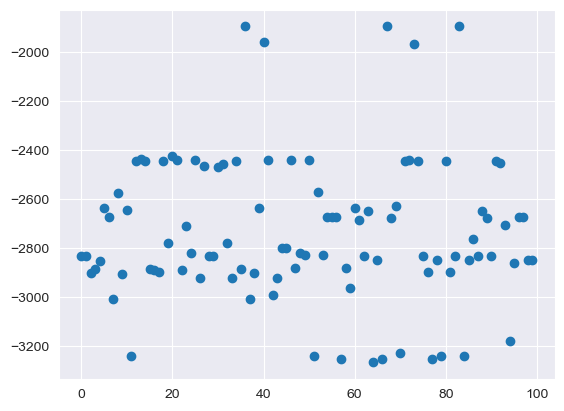

In [81]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

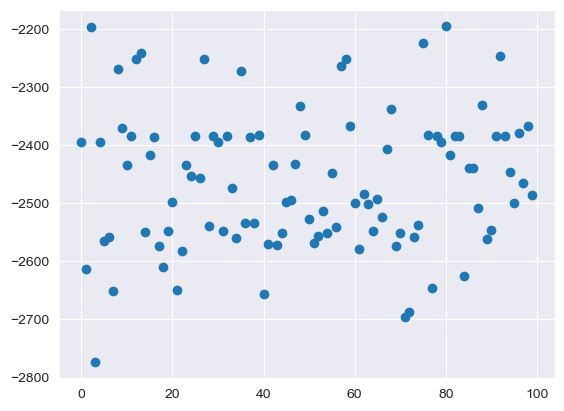

In [82]:
x = []
y = []
for i in range(len(winwebsec_observation_sequences_numeric_filtered)):
    x.append(i)
    y.append(classifierHMM_filtered.score((np.array([winwebsec_observation_sequences_numeric_filtered[i]]))))

plt.scatter(x, y)
plt.show()